In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# pyUserCalc

A jupyter notebook that attempts to recreate most of the functionality of Spiegelman's [UserCalc](http://www.ldeo.columbia.edu/~mspieg/UserCalc) website for calculating Uranium Series disequilibrium calculations for the Equilbrium transport model describe in 

Spiegelman, M., 2000. UserCalc: A Web-based uranium series calculator for magma migration problems. Geochem. Geophys. Geosyst. 1, 1016. https://doi.org/10.1029/1999GC000030


## Some plotting utilities

In [42]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=16
## Some utility functions for plotting

def plot_inputs(df,figsize=(8,6)):
    ''' 
        pretty plots input data from pandas dataframe df
    '''
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True,figsize=figsize)
    ax1.plot(df['F'],df['P'])
    ax1.invert_yaxis()
    ax1.set_xlabel('F')
    ax1.set_ylabel('Pressure (kb)')
    xticks = np.linspace(0,max(df['F']),10)
    ax1.grid()
    ax1.set_xticks(xticks,minor=True)
    ax2.plot(df['Kr'],df['P'])
    ax2.set_xlabel('Kr')
    for s in ['DU','DTh','DRa','DPa']:
        ax3.semilogx(df[s],df['P'],label=s)
    ax3.set_xlabel('Ds')
    ax3.legend(loc='best',bbox_to_anchor=(1.1,1))
    
def plot_1Dcolumn(df,figsize=(8,6)):
    '''
        pretty plots output data from dataframe of output
    '''
    
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=figsize)
    ax1.plot(df['phi'],df['P'],'r',label='$\phi$')
    ax1.set_xlabel('Porosity',color='r')
    ax1.set_ylabel('Pressure (kb)')
    ax1.invert_yaxis()

    ax1a = ax1.twiny()
    ax1a.plot(df['F'],df['P'],'b',label='$F$')
    ax1a.set_xlabel('Degree of melting',color='b')

    for s in ['(230Th/238U)','(226Ra/230Th)','(231Pa/235U)']:
        ax2.plot(df[s],df['P'],label=s)
    ax2.set_xlabel('Activity Ratios')
    ax2.set_xlim(0,5)
    ax2.set_xticks(range(5))
    ax2.grid()
    ax2.legend(loc='best',bbox_to_anchor=(1.1,1))
    return fig,(ax1,ax1a,ax2)

def plot_contours(phi0,W0,act,figsize=(8,8)):
    '''
    pretty plot activity contour plots
    '''
    
    Nplots = act.shape[0]
    if Nplots == 2:
        labels = ['(230Th/238U)', '(226Ra/230Th)']
    else:
        labels = ['(231Pa/235U)']
    
    
    if Nplots == 1:
        plt.figure(figsize=figsize)
        cf = plt.contourf(phi0,W0,act[0])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Porosity ($\phi_0$)')
        plt.ylabel('Upwelling Rate (cm/yr)')
        plt.gca().set_aspect('equal')
        plt.title(labels[0])
        plt.colorbar(cf, ax=plt.gca(), orientation='horizontal',shrink=1.)
    else:
        fig, axes = plt.subplots(1,Nplots,sharey=True,figsize=figsize)
        for i,ax in enumerate(axes):
            cf = ax.contourf(phi0,W0,act[i])
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_aspect('equal')
            ax.set_xlabel('Porosity ($\phi_0$)')
            ax.set_ylabel('Upwelling Rate (cm/yr)')
            ax.set_title(labels[i])
            fig.colorbar(cf, ax=ax, orientation='horizontal',shrink=1.)
        
    plt.show()


## A Generic Decay chain solver class

This class solves a generic radiocative decay chain problem for the logarithm of the radiogenic component of  melt concentration (Equation 9) in Spiegelman 2000

$$
    \frac{dU_i^r}{dz} = \lambda'_i\frac{\overline{\rho D_{i}}}{\overline{F D_{i}}}\left[ R_i^{i-1}\exp[U_{i-1}-U_i] - 1\right]
$$

where 
$$
    \lambda'_i = \frac{h\lambda_i}{W_0}
$$ 

are the decay constants scaled by the solid transport time ($h/W_0$) across a layer of depth $h$.

\begin{align}
    \overline{\rho D_{i}} &= \frac{\rho_f}{\rho_s}\phi + (1 -\phi)D_i\\
    \overline{F D_{i}} &= F + (1 -F)D_i
\end{align}

and

$$
    R_i^{i-1} = \alpha_i\frac{D_i^0}{D_{i-1}^0}\frac{\overline{\rho D_{i-1}}}{\overline{\rho D_{i}}}
$$

is the ingrowth factor. $\alpha$ is the initial degree of secular disequilibrium in the *unmelted solid*.

Note:  $U_i = \log(c_f/c_f^0)$ is the total log of the concentration of nuclide $i$ in the melt which can be decomposed into

$$
  U_i = U^s_i + U^r_i
$$

where

$$
    U^s_i = \log\left[ \frac{D_i^0}{\overline{FD}_i}\right]
$$

is the log concentration of a stable nuclide with the same partition coefficients.  U^r_i is the radiogenic ingrowth component.

In [3]:
from scipy.integrate import solve_ivp

class DecayChain:
    '''
    A class for calculating generic radioactive decay chains for the scaled equations 9 in Spiegelman (2000)
    
    Usage:  solver=DecayChain(alpha0,D0,lambdas,F_bar,rho_bar)
    
    inputs:
        alpha0  :  numpy array of initial activities
        D0      :  numpy array of initial partition coefficients
        lambdas :  decay constants scaled by solid transport time
        F_bar   :  Function that returns F + (1-F)D as a function of z'
        rho_bar :  Function that returns \rhof/rhos\phi + (1-\phi)D as a function of z'
        
    Outputs:  pandas DataFrame with columns z, U, U_s, U_r
    '''
    def __init__(self,alpha0,D0,lambdas,F_bar,rho_bar):
        self.alpha0 = alpha0
        self.D0 = D0
        self.lambdas = lambdas
        self.F_bar = F_bar
        self.rho_bar = rho_bar
        
    def rhs(self,z,Ur):
        '''
        returns right hand side of generic Decay chain problem for the log of the radiogenic concentration
        
        The full equation for dU/dz is given by Eq (9) in Spiegelman 2000 but here we split
        
        U = U^s + U^r where
        U^s is the log of the stable element concentrations U^s = log(D(0)/Fbar_z)
        U^r is the radiogenic ingrowth part
        
        the general equation is 
            dU_i^r/dz = h\lambda_i/Weff_i * [ R_i^{i-1} exp(U_{i-1} - U_i) - 1.)
            
        This routine assumes that lambda, D, D0, lambda_tmp, phi0, W_0 and alpha_0 are set by the driver routine
        '''
        
        # calculate F_bar(z) and rho_bar(z) once
        Fb = self.F_bar(z)
        rb = self.rho_bar(z)
        
        # initial value of partition coefficients
        D0 = self.D0
        # stable concentrations
        Us = np.log(D0/Fb)
        # total concentration
        U = Us + Ur
        # effective velocity and scaled rate term
        lambda_prime = self.lambdas*rb/Fb
        # ingrowth factor and exponential factor
        R = np.zeros(len(lambda_prime))
        expU = np.zeros(len(lambda_prime))
        for i in range(1,len(lambda_prime)):
            R[i] = self.alpha0[i]*D0[i]/D0[i-1]*rb[i-1]/rb[i]
            expU[i] = np.exp(U[i-1]-U[i])
            
        # return full RHS
        
        return lambda_prime*(R*expU - 1.)
        
    def solve(self,z_eval=None):
        '''
        solves generic radioactive decay chain problem as an ODE initial value problem
        if z_eval = None,  save every point
        else save output at every z_eval depth
        '''
        
        # Set initial condition and solve ODE      
        Ur_0 = np.zeros(len(self.D0))
        sol = solve_ivp(self.rhs,(0.,1.),Ur_0,t_eval=z_eval,method='RK45')
        z = sol.t
        Ur = sol.y
        # calculate stable concentration
        Us = np.log(self.D0/self.F_bar(z)).T 
        return z,Ur,Us
        
        

## The main UserCalc class

This class takes in a dataframe of inputs,  initializes the appropriate splines and porosity functions
then presents a set of methods for calculating 1D columns and contour maps

In [41]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d


class UserCalc:
    ''' A class for constructing solutions for Equilibrium Transport U-series calculations
        ala Spiegelman, 2000, G-cubed
        
        Usage: 
        us = UserCalc(df,dPdz = 0.32373, n = 2., tol=1.e-6, phi0 = 0.01, W0 = 3.) 
        
        with 
        df   :  a pandas-dataframe with columns ['P','Kr','DU','DTh','DRa','DPa']
        dPdz :  Pressure gradient to convert P to z
        n    :  permeability exponent
        tol  :  tolerance for ODE solver
        phi0 :  initial porosity
        W0   : upwelling velocity (cm/yr)
        
        Methods:
            
    '''
    def __init__(self, df, dPdz = 0.32373, n = 2., tol = 1.e-6, phi0 = 0.01, W0 = 3.):
        self.df = df
        self.dPdz = dPdz
        self.n = n
        self.tol = 1.e-6
        self.phi0 = phi0
        self.W0 = W0/1.e5
        
        # set depth scale h
        self.zmin = df['P'].min()/dPdz
        self.zmax = df['P'].max()/dPdz
        self.h = self.zmax - self.zmin
        
        # lambda function to define scaled column height zprime
        self.zp = lambda P: (self.zmax - P/dPdz)/self.h
        
        # set interpolants for F and Kr and pressure
        self.F = interp1d(self.zp(df['P']),df['F'],kind='cubic')
        self.Kr = interp1d(self.zp(df['P']),df['Kr'],kind='cubic')
        self.P = interp1d(self.zp(df['P']),df['P'],kind='cubic')

        # set maximum degree of melting
        self.Fmax = self.df['F'].max()
        
        # set reference densities (assuming a mantle composition)
        self.rho_s = 3300.
        self.rho_f = 2800.
        
        # set  decay constants for [ 238U, 230Th, 226Ra] and [ 235U, 231Pa ]       
        t_half_238 = np.array([4.468e9, 7.54e4, 1600.])
        t_half_235 = np.array([7.03e8, 3.276e4])
        self.lambdas_238 = np.log(2.)/t_half_238
        self.lambdas_235 = np.log(2.)/t_half_235
        
        # set interpolation functions for Partition coefficients for each chain
        self.D_238 = [ interp1d(self.zp(df['P']),df['DU'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DTh'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DRa'],kind='cubic') ]
        self.D_235 = [ interp1d(self.zp(df['P']),df['DU'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DPa'],kind='cubic')]
        
        # lambda function to get partition coefficients at zprime = 0
        self.get_D0 = lambda D: np.array([ D[i](0) for i in range(len(D))])
                        
        # initialize reference permeability
        self.setAd(self.phi0,n=n)
        
        # initialize porosity function
        
    def setAd(self,phi0,n):
        ''' 
            sets the reference permeability given the maximum porosity 
        '''
        Fmax = self.Fmax
        self.phi0 = phi0
        self.n = n
        self.Ad =  (self.rho_s/self.rho_f*Fmax - phi0*(1. - Fmax)/(1. - phi0))/(phi0**n*(1.-phi0))
        
    def phi(self,zp):
        '''
        returns porosity as function of dimensionless column height zp
        '''
        # effective permeability
        K = self.Kr(zp)*self.Ad
        
        # degree of melting
        F = self.F(zp)
        
        # density ratio
        rs_rf = self.rho_s/self.rho_f
        
        # rootfinding function to define porosity such that f(phi) = 0
        
        # check if scalar else loop
        if np.isscalar(zp):
             f = lambda phi: K*phi**self.n*(1. - phi)**2 + phi*(1. + F*(rs_rf - 1.)) - F*rs_rf
             phi = brentq(f,0.,1.)
        else: # loop over lenght of zp
            phi = np.zeros(zp.shape)
            for i,z in enumerate(zp):
                f = lambda phi: K[i]*phi**self.n*(1. - phi)**2 + phi*(1. + F[i]*(rs_rf - 1.)) - F[i]*rs_rf
                phi[i] = brentq(f,0.,1.)
        return phi
                
    def F_bar_D(self,zp,D):
        '''
        returns  numpy array of  size (len(zp),len(D)) for
        
        Fbar_D = F + (1. - F)*D_i
        '''
        
        F = self.F(zp)
        if np.isscalar(zp):
            F_bar_D = np.array([ F + (1. - F)*D[i](zp) for i in range(len(D))])
        else :
            F_bar_D = np.zeros((len(zp),len(D)))
            F_bar_D = np.array([ F + (1. - F)*D[i](zp) for i in range(len(D))]).T
        return F_bar_D
    
    def rho_bar_D(self,zp,D):
        '''
        returns  numpy array of  size (len(zp),len(D)) for
        
        rho_bar_D = rho_f/rho_s*phi + (1. - phi)*D_i
        '''
        rho_s = self.rho_s
        rho_f = self.rho_f
        
        phi = self.phi(zp)
        if np.isscalar(zp):
            rho_bar_D = np.array([ rho_f/rho_s*phi + (1. - phi)*D[i](zp) for i in range(len(D))])
        else: 
            rho_bar_D = np.zeros((len(zp),len(D)))
            rho_bar_D = np.array([ rho_f/rho_s*phi + (1. - phi)*D[i](zp) for i in range(len(D))]).T
           
        return rho_bar_D
    
    def set_column_params(self, phi0, n, W0 ):
        '''
        set porosity/permeability and upwelling rate parameters for a single column
        
        phi0: porosity at Fmax
        n   : permeability exponent
        W0  : upwelling rate (cm/yr)
        '''
    
        self.setAd(phi0,n)
        self.W0 = W0/1.e5 # upwelling in Km/yr
        
    def solve_1D(self,D,lambdas,alpha0 = None, z_eval = None):
        '''
        Solves 1-D decay problem (assumes column parameters have been set
        
        Usage:  z, a, Ur, Us = solve_1D(D,lambdas,alpha0,z_eval)
        
        Input
        D      :  function that returns bulk partition coefficients for each nuclide
        lambdas:  decay coefficients of each nuclide
        alpha0 :  initial activities of the nuclide in the unmelted solid (defaults to 1)
        z_eval :  dimensionless column heights where solution is returned
        
        
        Output: 
        z:   coordinates where evaluated
        a:   activities of each nuclide
        Ur:  radiogenic part of nuclide concentration
        Us:  stable component of nuclide concentration
        '''
        
        # if z_eval is not set, use initial Input values
        if z_eval is None:
            z_eval = self.zp(self.df['P'])
        elif np.isscalar(z_eval):
            z_eval = np.array([z_eval])
            
        # if alpha is not set, use 1
        if alpha0 is None:
            alpha0 = np.ones(len(lambdas))
        
        # scaled decay constants and initial partition coefficients    
        lambdap = self.h*lambdas/self.W0
        D0 = self.get_D0(D)
        
        F_bar = lambda  z: self.F_bar_D(z,D)
        rho_bar = lambda z: self.rho_bar_D(z,D)
        
        us = DecayChain(alpha0,D0,lambdap,F_bar,rho_bar)
        z, Ur, Us = us.solve(z_eval)
        U = Ur + Us
        # calculate activities
        act =  [ alpha0[i]/D0[i]*np.exp(U[i]) for i in range(len(D0)) ]
        return z, act, Ur, Us
        
        
        
        
    def solve_all_1D(self,phi0 ,n , W0, alphas = np.ones(4), z_eval = None):
        '''
        set's up and solves the 1-D column model for a given phi0,n, and upwelling rate W0 (in cm/yr)
        Solves for both the U238 Decay chain and the U235 decay chain
        
        Returns a pandas dataframe
        '''
    
        self.set_column_params(phi0,n,W0)
        
        # evaluate at input depths if not specified
        if z_eval is None:
            z_eval = self.zp(self.df['P'])
                    
        # solve for the U238 model
        z238, a238, Ur238, Us238 = self.solve_1D(self.D_238, self.lambdas_238, z_eval = z_eval)
        
        # solve for the U235 model
        z235, a235, Ur235, Us235 = self.solve_1D(self.D_235, self.lambdas_235, z_eval = z_eval)
        
        # start building output dataframe
        z = z_eval
        
        df = pd.DataFrame()
        df['P'] = self.P(z) 
        df['z'] = self.zmax - self.h*z
        df['F'] = self.F(z)
        df['phi'] = self.phi(z)
        names = ['(230Th/238U)','(226Ra/230Th)']
        for i,name in enumerate(names):
            df[name] = a238[i+1]/a238[i]
        
        df['(231Pa/235U)'] = a235[1]/a235[0]
        
        names = ['U_238U','U_230Th', 'U_226Ra']
        for i,name in enumerate(names):
            df[name] = Ur238[i] + Us238[i]
            
        names = ['U_235U','U_231Pa']
        for i,name in enumerate(names):
            df[name] = Ur235[i] + Us235[i]
        
        return df
    
    def solve_grid(self, phi0, n, W0, D, lambdas, alpha0 = None, z = 1.):
        '''
        solves of activity ratios at the height z in the column for a mesh grid of porosites phi0 and upwelling
        velocities W0 (slow, not vectorized)
        
        '''
        # number of nuclides in chain
        Nchain = len(lambdas)
        
        # if alpha is not set, use 1
        if alpha0 is None:
            alpha0 = np.ones(Nchain)
            
        act = np.zeros((Nchain - 1,len(W0),len(phi0)))
                       
        for j, W in enumerate(W0):
            print('\nW = {}'.format(W), end=" ")
            for i, phi in enumerate(phi0):
                print('.', end=" ")
                self.set_column_params(phi,n,W)
                z, a, Ur, Us = self.solve_1D(D,lambdas,alpha0,z_eval = z)
                for k in range(1,Nchain):
                    act[k-1,j,i] = a[k]/a[k-1]
        
        return act
    

## Let's look at some input data

In [5]:
df = pd.read_csv('data/sample.csv',skiprows=1,dtype=float)

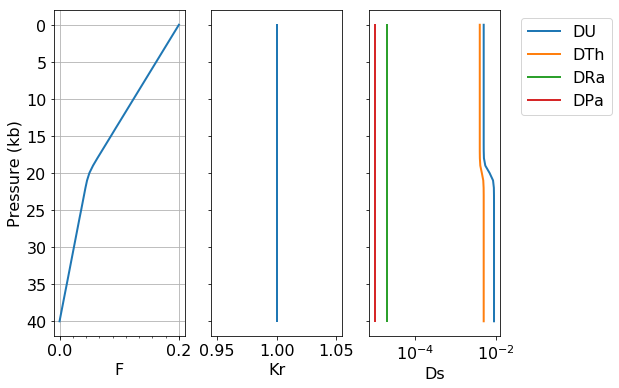

In [6]:
plot_inputs(df)

In [7]:
df

,P,F,Kr,DU,DTh,DRa,DPa
0,40.0,0.00000,1.0,0.00900,0.00500,0.00002,0.00001
1,39.0,0.00241,1.0,0.00900,0.00500,0.00002,0.00001
2,38.0,0.00482,1.0,0.00900,0.00500,0.00002,0.00001
3,37.0,0.00723,1.0,0.00900,0.00500,0.00002,0.00001
4,36.0,0.00964,1.0,0.00900,0.00500,0.00002,0.00001
5,35.0,0.01210,1.0,0.00900,0.00500,0.00002,0.00001
6,34.0,0.01450,1.0,0.00900,0.00500,0.00002,0.00001
7,33.0,0.01690,1.0,0.00900,0.00500,0.00002,0.00001
8,32.0,0.01930,1.0,0.00900,0.00500,0.00002,0.00001
9,31.0,0.02170,1.0,0.00900,0.00500,0.00002,0.00001


### Solve the 1-D column problem

In [8]:
# initialze the solver object
us = UserCalc(df)

# set column parameters
phi0 = 0.008
W0 = 3. # cm/yr
n = 2.

df_out = us.solve_all_1D(phi0,n,W0)

## activities at the top of the column

In [9]:
df_out[['(230Th/238U)','(226Ra/230Th)','(231Pa/235U)']].iloc[-1]

(230Th/238U)     1.164940
(226Ra/230Th)    1.590509
(231Pa/235U)     2.110607
Name: 40, dtype: float64

## Plot solution

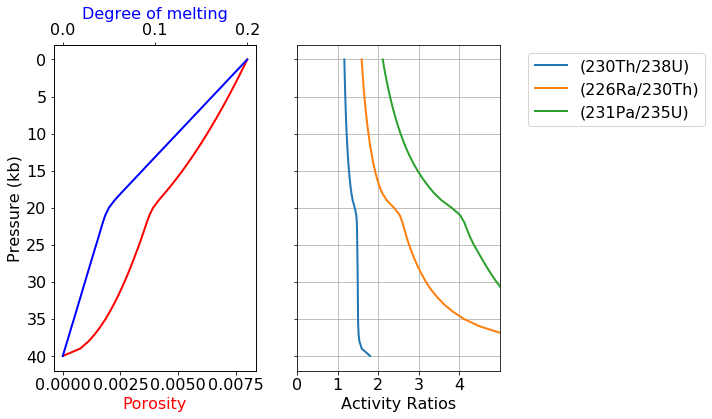

In [10]:
plot_1Dcolumn(df_out)
plt.show()

## view dataframe

In [11]:
df_out

,P,z,F,phi,(230Th/238U),(226Ra/230Th),(231Pa/235U),U_238U,U_230Th,U_226Ra,U_235U,U_231Pa
0,40.0,123.559757,0.00000,0.000000,1.800000,250.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,39.0,120.470763,0.00241,0.000760,1.591797,8.322541,8.592876,-0.235378,-0.358301,-3.760794,-0.235457,-4.886918
2,38.0,117.381769,0.00482,0.001124,1.534689,6.049642,6.995069,-0.425776,-0.585235,-4.306696,-0.425922,-5.283111
3,37.0,114.292775,0.00723,0.001406,1.515332,5.073467,6.399061,-0.585658,-0.757810,-4.655246,-0.585861,-5.532105
4,36.0,111.203781,0.00964,0.001643,1.507677,4.501108,6.039430,-0.723467,-0.900684,-4.917821,-0.723722,-5.727807
5,35.0,108.114787,0.01210,0.001857,1.503329,4.108796,5.760839,-0.846930,-1.027035,-5.135366,-0.847230,-5.898541
6,34.0,105.025793,0.01450,0.002045,1.501545,3.834329,5.548278,-0.954271,-1.135563,-5.313030,-0.954612,-6.043519
7,33.0,101.936799,0.01690,0.002218,1.500015,3.613635,5.362455,-1.051199,-1.233511,-5.470258,-1.051577,-6.174550
8,32.0,98.847805,0.01930,0.002380,1.498431,3.443219,5.197193,-1.139558,-1.322926,-5.607980,-1.139971,-6.294247
9,31.0,95.758811,0.02170,0.002532,1.496685,3.293580,5.049391,-1.220739,-1.405274,-5.734759,-1.221185,-6.404312


## Calculated gridded activity ratios at the top of the colum

In [12]:
phi0 = np.logspace(-3,-1,11)
W0 = np.logspace(-1,1,11)
n = 2.
act = us.solve_grid(phi0, n, W0, us.D_238, us.lambdas_238 )

[0.001      0.00158489 0.00251189 0.00398107 0.00630957 0.01
 0.01584893 0.02511886 0.03981072 0.06309573 0.1       ] [ 0.1         0.15848932  0.25118864  0.39810717  0.63095734  1.
  1.58489319  2.51188643  3.98107171  6.30957344 10.        ]

W = 0.1 . . . . . . . . . . . 
W = 0.15848931924611134 . . . . . . . . . . . 
W = 0.251188643150958 . . . . . . . . . . . 
W = 0.3981071705534973 . . . . . . . . . . . 
W = 0.6309573444801934 . . . . . . . . . . . 
W = 1.0 . . . . . . . . . . . 
W = 1.584893192461114 . . . . . . . . . . . 
W = 2.511886431509581 . . . . . . . . . . . 
W = 3.981071705534973 . . . . . . . . . . . 
W = 6.309573444801933 . . . . . . . . . . . 
W = 10.0 . . . . . . . . . . . 

In [16]:
act_235 = us.solve_grid(phi0, n, W0, us.D_235, us.lambdas_235 )


W = 0.1 . . . . . . . . . . . 
W = 0.15848931924611134 . . . . . . . . . . . 
W = 0.251188643150958 . . . . . . . . . . . 
W = 0.3981071705534973 . . . . . . . . . . . 
W = 0.6309573444801934 . . . . . . . . . . . 
W = 1.0 . . . . . . . . . 

/Users/mspieg/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)


. . 
W = 1.584893192461114 . . . . . . . . . . . 
W = 2.511886431509581 . . . . . . . . . . . 
W = 3.981071705534973 . . . . . . . . . . . 
W = 6.309573444801933 . . . . . . . . . . . 
W = 10.0 . . . . . . . . . . . 

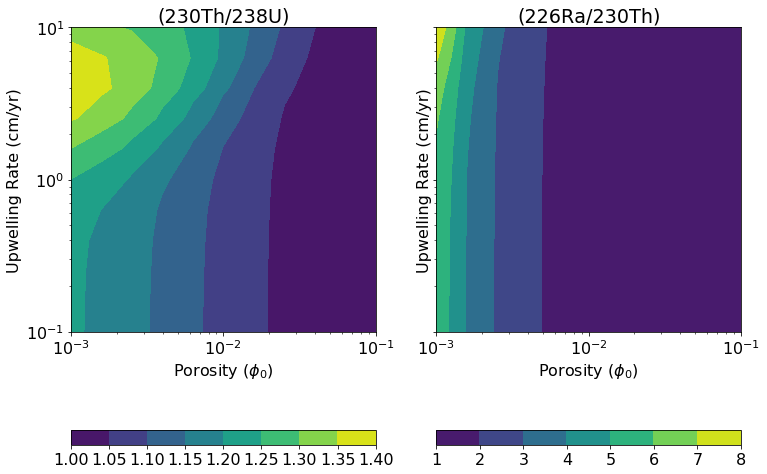

In [43]:
plot_contours(phi0,W0,act,figsize=(12,12))

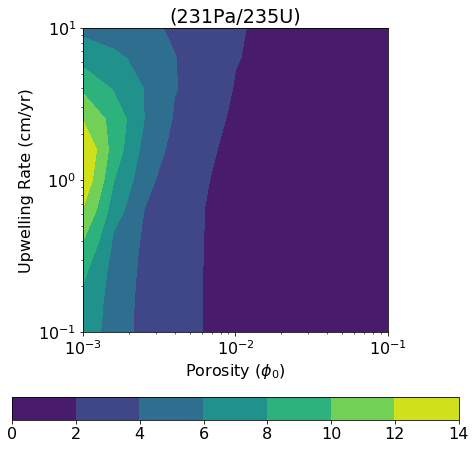

In [44]:
plot_contours(phi0,W0,act_235,figsize=(8,8))